In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# For reproducibility
np.random.seed(42)

# Number of time steps
n = 1000

# Generate normal system metrics
cpu = np.random.normal(loc=40, scale=5, size=n)
memory = np.random.normal(loc=60, scale=7, size=n)
disk = np.random.normal(loc=50, scale=6, size=n)
network = np.random.normal(loc=100, scale=10, size=n)

# Create DataFrame
data = pd.DataFrame({
    "cpu": cpu,
    "memory": memory,
    "disk": disk,
    "network": network
})

# Inject anomalies
anomaly_indices = np.random.choice(n, size=30, replace=False)
data.loc[anomaly_indices, "cpu"] += np.random.normal(40, 10, size=30)
data.loc[anomaly_indices, "memory"] += np.random.normal(30, 8, size=30)

data.head()


,cpu,memory,disk,network
0,42.483571,69.795488,45.948930,80.921924
1,39.308678,66.472436,49.132888,91.396150
2,43.238443,60.417413,45.245480,95.863945
3,47.615149,55.471443,48.152231,118.876877
4,38.829233,64.887563,38.638312,105.565531


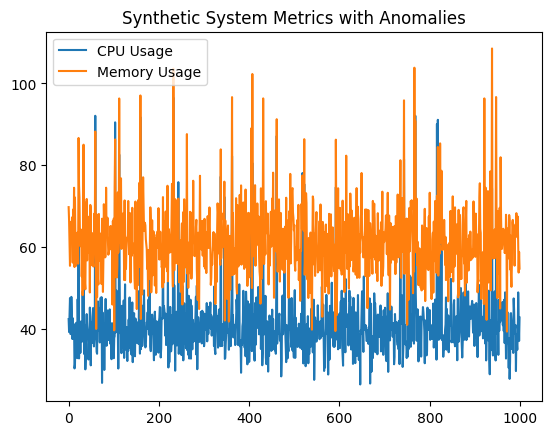

In [2]:
plt.figure()
plt.plot(data["cpu"], label="CPU Usage")
plt.plot(data["memory"], label="Memory Usage")
plt.legend()
plt.title("Synthetic System Metrics with Anomalies")
plt.show()


In [3]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

scaled_df = pd.DataFrame(
    scaled_data,
    columns=data.columns
)

scaled_df.head()


,cpu,memory,disk,network
0,0.228109,0.439653,0.337521,0.165514
1,0.182754,0.391560,0.413921,0.335204
2,0.238893,0.303927,0.320641,0.407586
3,0.301415,0.232346,0.390390,0.780414
4,0.175905,0.368622,0.162099,0.564760


In [4]:
# Remove extreme values (approx anomaly filtering)
threshold = scaled_df.quantile(0.97)

normal_data = scaled_df[
    (scaled_df < threshold).all(axis=1)
]

print("Total samples:", len(scaled_df))
print("Normal samples for training:", len(normal_data))


Total samples: 1000
Normal samples for training: 908


In [5]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam

input_dim = normal_data.shape[1]

# Encoder
input_layer = Input(shape=(input_dim,))
encoded = Dense(8, activation='relu')(input_layer)
encoded = Dense(4, activation='relu')(encoded)

# Decoder
decoded = Dense(8, activation='relu')(encoded)
decoded = Dense(input_dim, activation='linear')(decoded)

# Autoencoder
autoencoder = Model(inputs=input_layer, outputs=decoded)

autoencoder.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='mse'
)

autoencoder.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 4)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 8)              │            40 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │            36 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 8)              │            40 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │            36 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 152 (608.00 B)

 Trainable params: 152 (608.00 B)

 Non-trainable params: 0 (0.00 B)

In [6]:
history = autoencoder.fit(
    normal_data,
    normal_data,
    epochs=30,
    batch_size=32,
    validation_split=0.1,
    verbose=1
)


Epoch 1/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.1406 - val_loss: 0.1297
Epoch 2/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1169 - val_loss: 0.1092
Epoch 3/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0970 - val_loss: 0.0871
Epoch 4/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0754 - val_loss: 0.0613
Epoch 5/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0507 - val_loss: 0.0359
Epoch 6/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0286 - val_loss: 0.0194
Epoch 7/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0161 - val_loss: 0.0118
Epoch 8/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0104 - val_loss: 0.0088
Epoch 9/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0080 - val_loss: 0.0077
Epoch 10/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0074 - val_loss: 0.0072
Epoch 11/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0069 - val_loss: 0.0069
Epoch 12/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0067 - val_l

In [7]:
# Reconstruct all data
reconstructions = autoencoder.predict(scaled_df)

# Calculate reconstruction error (MSE)
reconstruction_error = np.mean(
    np.square(scaled_df - reconstructions),
    axis=1
)

reconstruction_error[:10]


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


,0
0,0.012050
1,0.003676
2,0.001160
3,0.008678
4,0.002536
5,0.002204
6,0.005679
7,0.005119
8,0.000488
9,0.001219


In [8]:
# Threshold: mean + 3 standard deviations
threshold = reconstruction_error.mean() + 3 * reconstruction_error.std()

print("Anomaly threshold:", threshold)


Anomaly threshold: 0.07848508527010392


In [10]:
results = pd.DataFrame({'reconstruction_error': reconstruction_error})
results['anomaly'] = results['reconstruction_error'] > threshold

print("Total anomalies detected:", results["anomaly"].sum())

Total anomalies detected: 22


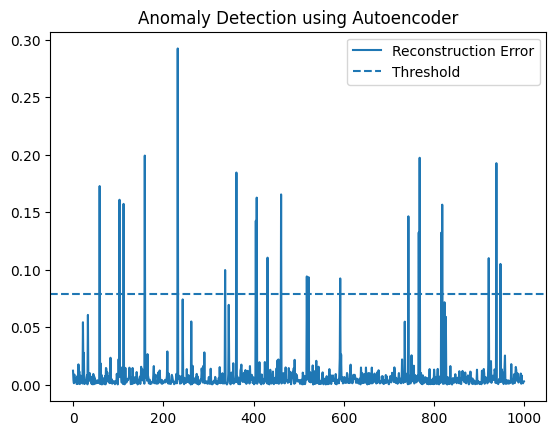

In [11]:
plt.figure()
plt.plot(reconstruction_error, label="Reconstruction Error")
plt.axhline(threshold, linestyle="--", label="Threshold")
plt.legend()
plt.title("Anomaly Detection using Autoencoder")
plt.show()


In [12]:
def smart_incident_agent(row, index):
    print(f"\n🚨 INCIDENT DETECTED at time step {index}")
    print(f"Reconstruction Error: {row['reconstruction_error']:.4f}")

    print("Affected Metrics:")
    for metric in ["cpu", "memory", "disk", "network"]:
        print(f"  {metric}: {row[metric]:.2f}")

    print("Action Taken:")
    print("  → Alert sent to DevOps team")
    print("  → Diagnostic data collected")


In [14]:
for idx, anomaly_row_data in results.iterrows():
    if anomaly_row_data["anomaly"]:
        # Get the original data for this index
        original_metrics_row = data.loc[idx]

        # Combine the anomaly information and original metrics into a single Series
        combined_row_data = pd.concat([original_metrics_row, anomaly_row_data])

        # Call the smart_incident_agent with the combined data
        smart_incident_agent(combined_row_data, idx)


🚨 INCIDENT DETECTED at time step 59
Reconstruction Error: 0.1727
Affected Metrics:
  cpu: 92.09
  memory: 88.24
  disk: 51.16
  network: 96.04
Action Taken:
  → Alert sent to DevOps team
  → Diagnostic data collected

🚨 INCIDENT DETECTED at time step 103
Reconstruction Error: 0.1608
Affected Metrics:
  cpu: 90.49
  memory: 86.31
  disk: 56.75
  network: 110.71
Action Taken:
  → Alert sent to DevOps team
  → Diagnostic data collected

🚨 INCIDENT DETECTED at time step 112
Reconstruction Error: 0.1572
Affected Metrics:
  cpu: 82.63
  memory: 96.32
  disk: 50.25
  network: 96.99
Action Taken:
  → Alert sent to DevOps team
  → Diagnostic data collected

🚨 INCIDENT DETECTED at time step 159
Reconstruction Error: 0.1992
Affected Metrics:
  cpu: 91.80
  memory: 97.05
  disk: 53.35
  network: 103.13
Action Taken:
  → Alert sent to DevOps team
  → Diagnostic data collected

🚨 INCIDENT DETECTED at time step 232
Reconstruction Error: 0.2924
Affected Metrics:
  cpu: 96.52
  memory: 103.59
  disk: 